In [1]:
# Google Colab, clone the repository for helper functions
%rm -rf * && rm -rf .*
!git clone https://github.com/Asheeshkrsharma/Identification-OpenCows.git .

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 279 (delta 30), reused 50 (delta 16), pack-reused 213
Receiving objects: 100% (279/279), 517.58 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Checking out files: 100% (50/50), done.


In [2]:
# !pip3 install hiddenlayer
# !pip3 install tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
import hiddenlayer as hl
from tqdm import tqdm
from torch import optim
import numpy
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from utils.OpenSetCows2021 import OpenSetCows2021TrackLet

In [3]:
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message); pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/datasetLinks.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2020 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/datasetLinks.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2020
  %mv -f ./datasets/*/identification ./datasets/OpenSetCows2020/ 2>/dev/null
  %rm -rf ./datasets/10m32xl88x2b61zlkkgz3fml17
  pbar.update()
!tree -C -d -L 3 -h ./datasets

Organizing dataset: 100%|██████████| 2/2 [02:42<00:00, 81.19s/it]

/bin/bash: tree: command not found


In [ ]:
# Opencows 2021
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message);
  pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/opencows2021.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2021 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/opencows2021.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2021
  %mv -f ./datasets/*/Sub-levels ./datasets/OpenSetCows2021/ 2>/dev/null
  %rm -rf ./datasets/4vnrca7qw1642qlwxjadp87h7
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [07:42<00:00, 231.38s/it]


In [5]:
class Lstm(nn.Module):
    def __init__(self, inputSize, embeddingSize):
        super(Lstm, self).__init__()
        # self.Lstm = torch.nn.LSTM(input_size=inputSize,
        #                           hidden_size=embeddingSize,
        #                           num_layers=1, dropout=0.5, batch_first=True)
        self.Lstm = torch.nn.LSTM(input_size=inputSize,
                                  hidden_size=embeddingSize,
                                  num_layers=2, dropout=0.5, batch_first=True)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self,x):
        output, self.hidden_state = self.Lstm(x, self.hidden_state)
        return output, self.hidden_state

class LRResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        super(LRResNetMod, self).__init__()
        
        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=False)
        imagenetWeights = model_zoo.load_url(
            "https://data.bris.ac.uk/datasets/4vnrca7qw1642qlwxjadp87h7/Sub-levels/Weights/Identification/current025_model_state.pkl"
        )

        self.backbone.fc_embedding = nn.Linear(1000, embeddingSize)
        self.backbone.load_state_dict(imagenetWeights['model_state'])
        
        # We are now going to modify this layer
        # self.backbone.fc_embedding = nn.Linear(1000, 512)

        for m in self.backbone.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

        self.relu = nn.ReLU(inplace=True)

        # for param in self.ResnetMod.parameters():
        #   param.requires_grad = False
        
        # self.lstm = Lstm(512, 256)
        self.lstm = Lstm(2048, 1000)
        # self.lstm = torch.nn.LSTM(input_size=2048,
        #                   hidden_size=1000,
        #                   num_layers=1, batch_first=True)
        self.embedding = nn.Linear(1000, embeddingSize)
        self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        # x has the following shape: 
        # [
        #     Batch,
        #     sequence length (needs to be same for accross the batch,
        #     dynamic batching will be add later),
        #     channel,
        #     image height, image width
        # ]
        batch, timesteps, channels, h, w = x.shape
        x = x.view(batch * timesteps, channels, h, w)

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )

        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )

        # Relu(FC)
        # x = self.backbone.relu(self.backbone.fc(x.view(x.size(0), -1)))
        x = x.view(x.size(0), -1)
        # x = self.backbone.fc_embedding(x)

        # Batch, number of images in each sequence, embddeing size
        x = x.view(batch, timesteps, -1)

        # Batch, number of images in each sequence, embddeing size
        x, _ = self.lstm(x)
        
        x_t = self.embedding(x)
        # Batch, numclasses
        # return x_t, x_t.mean(dim=1), torch.mean(self.softmax(x), dim=1)
        return x_t, x_t[:,-1,:], torch.mean(self.softmax(x), dim=1)
        # return x_t, x_t[:,-1,:], self.softmax(x)[:,-1,:]

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        # Must be done before you run a new batch. Otherwise the LSTM will
        # treat a new batch as a continuation of a sequence
        self.lstm.reset_hidden_state()
        if (negative != None) & (positive != None):
            _, negativeEMBD, negativeSMax = self.forwardOnce(negative)
            _, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            _, positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD,
                anchorEMBD,
                positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            em, anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return em, anchorEMBD, anchorSMax

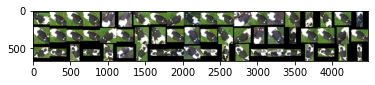

1 8


In [6]:
import matplotlib.pyplot as plt

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020.json",
    maxSequenceLength=20,
    transform=False,
)

# Test
negative, anchor, positive, positiveLabel, negativeLabel = trainingDataset.__getitem__(1)
anc = [a.permute(1, 2, 0).numpy() for a in anchor]
pos = [a.permute(1, 2, 0).numpy() for a in positive]
neg = [a.permute(1, 2, 0).numpy() for a in negative]

# Function to compose images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img if horizontal == 1 else img for img in images],
    axis=horizontal,
)

plt.imshow(compose([compose(anc, 1), compose(pos, 1), compose(neg, 1)], 0))
plt.show()
print(positiveLabel, negativeLabel)


In [79]:
import torch.nn.functional as F

class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        return (anchor - instance).pow(2).sum(1)

    def forward(self, negative, anchor, positive, prediction=None, target=None):
        return self.d(anchor, positive) + (1 / self.d(anchor, negative))

class RTLSL(nn.Module):
    def __init__(self, _lambda=0.01):
        super(RTLSL, self).__init__()
        self._lambda = _lambda
        self.RTL = RTL()
        self.CE = nn.CrossEntropyLoss(label_smoothing=0.3)
        # self.CE = nn.CrossEntropyLoss()

    def forward(self, negative, anchor, positive, prediction, target):
        rtlLoss = self.RTL(negative, anchor, positive)
        entropy = self.CE(input=prediction, target=target - 1)
        return self._lambda * rtlLoss.mean() + entropy
        # return self._lambda * rtlLoss.sum() + entropy

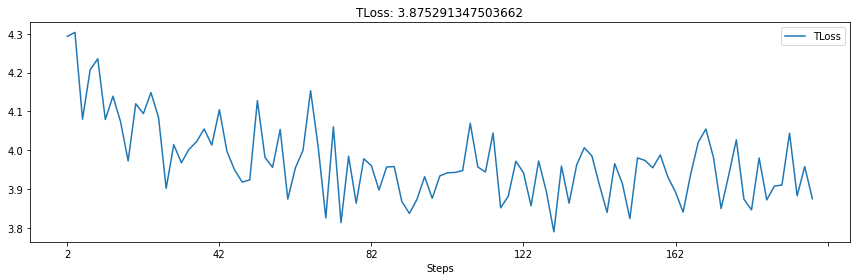

Training epochs: 100%|██████████| 200/200 [08:09<00:00,  2.45s/it]


In [88]:
trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020.json",
    maxSequenceLength=10,
    transform=True
)

# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# There are 155 individuals in the dataset
model = LRResNetMod(46)
model.to(device)

# Working parameter (71%)
trainingDataLoader = DataLoader(
    trainingDataset, batch_size=4, num_workers=1, shuffle=True
)

optimiser = optim.SGD(model.parameters(), momentum=0.0, lr=1e-2, weight_decay=1e-5)

# We will use cross entropy loss for the training
lossFN = RTLSL(0.1)

loss, numEpochs = 0, 200

# To store the training history
history, canvas = hl.History(), hl.Canvas()

with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    # Start training
    model.train()
    for epoch in range(numEpochs):
        # Prepare a batch of 5 sequences with 10 images each
        # with three channels and (224, 224) size
        negatives, anchor, positives, positiveLabel, negativeLabel = next(
            iter(trainingDataLoader)
        )
        negatives, anchor, positives = (
            negatives.to(device),
            anchor.to(device),
            positives.to(device),
        )
        positiveLabel, negativeLabel = (
            positiveLabel.view(len(positiveLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device),
        )

        # Calculate loss and Back propagate
        def backPropagate():
            optimiser.zero_grad()
            negativeEMBD, anchorEMBD, positiveEMBD, labels = model(
                anchor, negatives, positives
            )
            loss = lossFN(
                negativeEMBD, anchorEMBD,
                positiveEMBD, labels,
                torch.cat((positiveLabel, positiveLabel, negativeLabel), dim=0),
            )
            loss.backward()
            return loss

        loss = optimiser.step(backPropagate)
        # Every second iteration, calculate model accuracy, evaluate the loss
        # function on the test dataset. Save the experiment history
        if epoch % 2 == 0 and epoch > 0:
            history.log(epoch, TLoss=loss.data)
            model.train()
            with canvas:
                canvas.draw_plot([history["TLoss"]])
        pbar.update()
    pbar.refresh()


In [89]:
modelPrefix = 'LRCNN'
torch.save(model.state_dict(), f"./models/{modelPrefix}.pth")

In [91]:
# Get the device, prefer Cuda over CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = LRResNetMod(46)
model.load_state_dict(torch.load('models/LRCNN.pth'))
model.to(device)

trainingDataset = OpenSetCows2021TrackLet(
    "/content/datasets/OpenSetCows2020",
    "utils/opencowsTracklets2020.json",
    maxSequenceLength=None,
    transform=False
)

embeddings  = numpy.zeros((1, 128))
predictions = numpy.zeros((1))
groundTruth = numpy.zeros((1))

embeddingsAll  = numpy.zeros((1, 128))
predictionsAll = numpy.zeros((1))

model.eval()
correct = 0
with torch.no_grad():
  for i in tqdm(range(trainingDataset.__len__()), desc="Inferencing tracklets"):
    tracklet, label = trainingDataset.__getitem__(i)
    # tracklet = tracklet[:7, :, :, :]
    tracklet = tracklet.to(device)
    all, embd, pred = model(tracklet[None, :])

    all = all.data.cpu().numpy()
    embeddingsAll = numpy.concatenate((embeddingsAll, all[0]), axis=0)

    # numpy.ones(1, tracklet.shape[0])
    predictionsAll = numpy.concatenate((predictionsAll, numpy.ones(tracklet.shape[0]) * label))
    
    # max_value, max_index = pred.max(1, keepdim=True)
    # correct += max_index.eq(label).sum().item()

    pred = pred.max(1).indices.cpu().numpy()
    embd = embd.data.cpu().numpy()
    embeddings = numpy.concatenate((embeddings, embd), axis=0)
    predictions = numpy.concatenate((predictions, pred), axis=0)
    groundTruth = numpy.concatenate((groundTruth, numpy.array([label])), axis=0)
predictions, embeddings, groundTruth = predictions[1:], embeddings[1:], groundTruth[1:]
embeddingsAll, predictionsAll = embeddingsAll[1:], predictionsAll[1:]

Inferencing tracklets: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s]


In [92]:
# Model accuracy
accuracy = lambda p, l:  numpy.mean(p.astype(int).ravel() == l.astype(int).ravel()) * 100

KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
KNN.fit(embeddingsAll, predictionsAll - 1)

# We compare just the last output for the evaluating the model accuracy
print("KNN accuracy: {}%".format(accuracy(KNN.predict(embeddings), groundTruth - 1)))

KNN accuracy: 88.13559322033898%


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
No handles with labels found to put in legend.


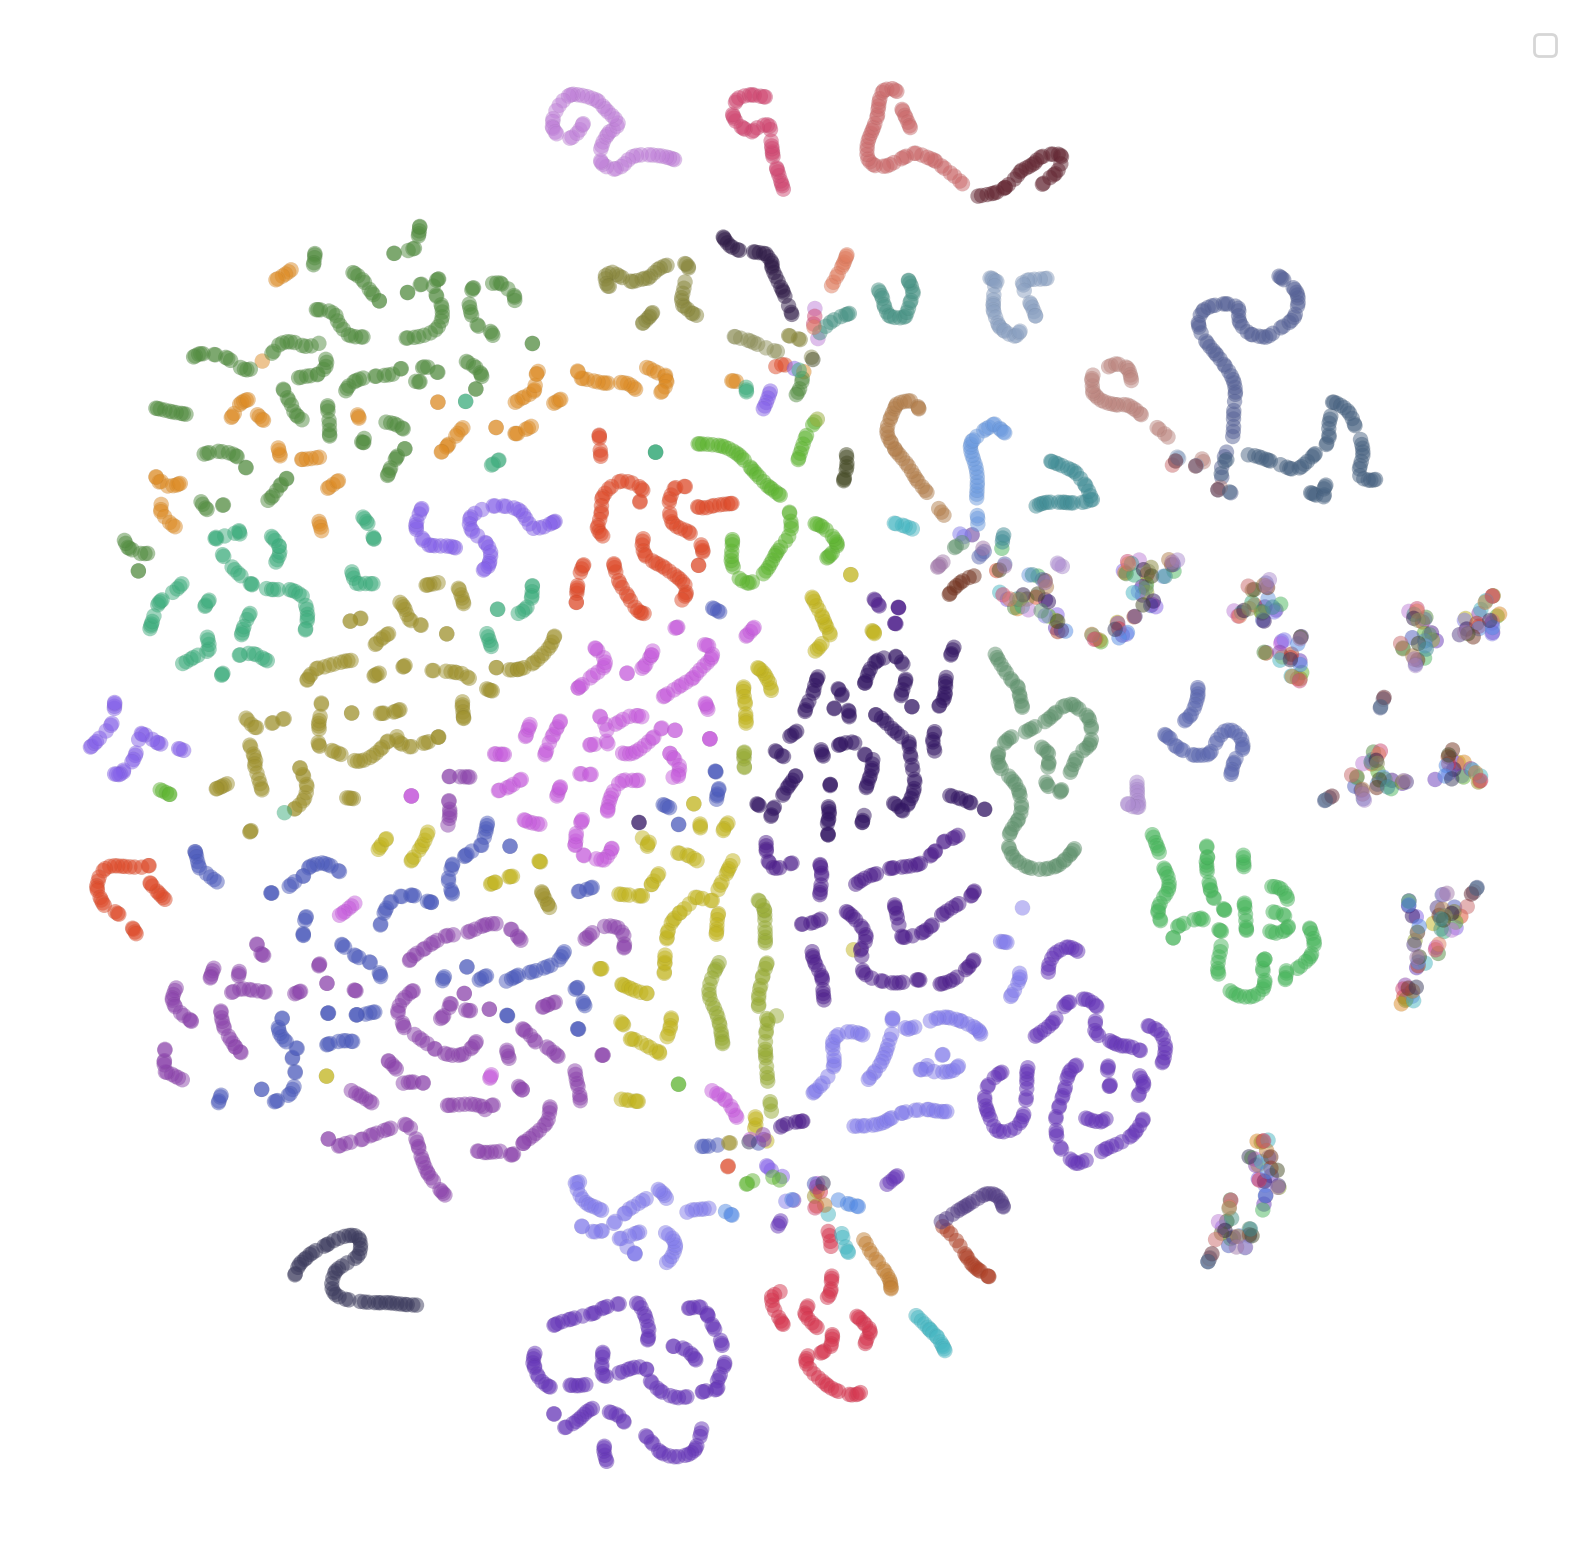

In [93]:
import matplotlib.pyplot as plt

# perplexity mentioned in the paper is 30, rest arguments are mentioned as useful defaults
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=8, init='pca')
reduction = tSNE.fit_transform(embeddingsAll)
# colors = ["#00041a","#89e847","#0c1bc0","#c7dc39","#29009d","#00ad34","#bc25de","#01ea8c","#b400be","#01b144","#0030c5","#ffc126","#024fe6","#549b00","#cc60ff","#046200","#e800b3","#00b065","#ff4bd4","#007926","#f976ff","#01aa67","#ff28b0","#53eaad","#a100a6","#a2e27d","#016af9","#f09600","#00005a","#eccf5b","#001672","#ff8b18","#0072d8","#ee2b00","#00e8d4","#fb004f","#41eab5","#890092","#007d35","#ff69ea","#01c198","#e7007e","#75e5bf","#e90071","#45e6e4","#ff4143","#42e3ff","#ff6335","#1ba0ff","#eb7500","#012f89","#d59100","#4c0072","#ffba4e","#014fa6","#c37300","#d089ff","#667500","#9f0085","#9fe19b","#9f0078","#8ae3ad","#dd0060","#008551","#ff467c","#00c8d5","#ff4f5f","#54e3f3","#932500","#0099e3","#ff9548","#001c44","#c3da8b","#30003a","#d7d484","#1c002f","#c3d9a0","#2a0032","#ded293","#000e2d","#ff7752","#00a2d9","#ad4e00","#77b8ff","#987e00","#b2a2ff","#556800","#f7a3ff","#004710","#ff66b3","#294700","#ff90cf","#003f1c","#ff769b","#00301c","#ff7362","#02b9d0","#9b002a","#7ee1de","#730100","#7adeff","#84001c","#009fa4","#a3004d","#007d6d","#810046","#9fdcdb","#60004d","#c7d7ac","#75004d","#a6d5ff","#934d00","#b3c1ff","#7b3600","#e9c4fa","#112800","#ffb4d1","#0a1500","#f1c4e4","#120014","#f2ca9f","#15001a","#f7c6b1","#001930","#ffa18a","#00161f","#ffb1a6","#002548","#805600","#003464","#ff93a6","#005b49","#820035","#00828b","#5e001e","#ddccd9","#1e000a","#f3c6c2","#22000f","#ffafb9","#211400","#017199","#5d1d00","#006e82","#481400","#00515d","#400029","#4f4600","#2c001b","#2a3500","#003e4c","#513500","#005150","#402400","#282500"]
colors = numpy.asarray(
    [
        [102, 162, 209], [222, 74, 41], [132, 96, 233], [94, 181, 49],
        [102, 54, 184], [194, 180, 29], [78, 31, 140], [72, 182, 92],
        [198, 92, 220], [151, 171, 52], [130, 123, 235], [221, 139, 36],
        [76, 91, 188], [159, 146, 46], [140, 68, 172], [83, 141, 65],
        [50, 21, 99], [61, 173, 125], [214, 54, 79], [70, 183, 195],
        [175, 66, 40], [83, 138, 229], [195, 128, 52], [84, 62, 134],
        [137, 135, 60], [191, 127, 216], [97, 147, 110], [208, 72, 114],
        [73, 148, 134], [224, 124, 94], [107, 154, 223], [114, 50, 30],
        [92, 104, 176], [179, 126, 75], [48, 28, 72], [144, 146, 93],
        [173, 140, 208], [71, 76, 39], [162, 120, 170], [65, 141, 150],
        [203, 105, 106], [86, 98, 151], [188, 133, 126], [59, 58, 93],
        [137, 159, 193], [101, 40, 52], [72, 99, 130],
    ]
)
# faceColors = [colors[int(label)] for label in predictionsAll]
faceColors = [colors[int(label)] / 255. for label in predictionsAll]

plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)
plt.scatter(reduction[:, 0], reduction[:, 1], s=30, alpha=0.5, edgecolor="#262626", linewidth=0.02, facecolor=faceColors)
# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()
plt.show()

In [ ]:
# TODOs
# [1] Support triplets
# [2] Top N accuracy
# [3] Incorporate Test set tracklets
# [4] Train on first few week, see how it performs on the next few.